<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_10%5DLet's_make_a_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Exp_10]Let's make a translator

## 1.import 및 데이터로드

### 1) Import

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow as tf

### 2) 데이터로드

In [2]:
file_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/translator_seq2seq/fra.txt"
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플수:',len(lines))
lines.sample(5)

전체 샘플수: 194513


,eng,fra,cc
4400,Are you deaf?,Êtes-vous sourd ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
79195,I was expecting the worst.,Je m'attendais au pire.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
140452,Please take a look at this picture.,Regardez cette image s'il vous plaît.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
81476,The hunter caught the fox.,Le chasseur prit le renard.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
82451,Tom will be there tonight.,Tom sera là ce soir.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...



데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다

In [3]:
lines = lines[['eng', 'fra']][:33000]
lines.sample(5)

,eng,fra
392,Show me.,Montre-moi !
21555,What a cute girl!,Quelle jolie fille !
22781,Does Tom know you?,Est-ce que Tom te connaît ?
22866,Enjoy your flight.,Bon vol !
21177,Tom won the game.,Tom a gagné la partie.


## 2. 데이터 전처리 작업


### 1)  정제, 정규화 & 케라스의 토크나이저로 텍스트를 숫자로 & 디코더 문장에 시작 토큰과 종료 토큰 입력

- 구두점(Punctuation)을 단어와 분리
- 소문자로 change
- 띄어쓰기 단위로 토큰을 수행
  - (토크나이저에 옵션을 줌으로 텍스트 숫자로 변환과 동시진행 가능)
  - (디코더 문장의 경우 토크나이저 직전에 시작 토큰과 종료 토큰 입력 가능)

- 참고 자료
  - https://soraji.github.io/python/2019/07/21/rex/
  - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [4]:
def preprocess_sentence(sentence):
  sentence = sentence.str.lower()
  sentence = sentence.str.replace(pat=r'([?.!,¿])', repl =r" \1 ")
  sentence = sentence.str.replace(pat=r'[" "]+', repl =" ")
  sentence = sentence.str.replace(pat=r"[^a-zA-Z?.!,¿]+", repl =" ")
  sentence = sentence.str.strip() 

  return sentence

In [5]:
input_text = preprocess_sentence(lines.eng)
eng_tokenizer = Tokenizer(split=' ', filters="")   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(input_text)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(input_text)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


[[29, 1], [29, 1], [29, 1]]

In [6]:
target_text = preprocess_sentence(lines.fra)

# 디코더에 시작 토큰과 종료토큰 추가
sos_token = '\t'
eos_token = '\n'
target_text= target_text.apply(lambda x : '\t '+ x + ' \n')
print(target_text)

fra_tokenizer = Tokenizer(split=' ', filters="")   # 문자 단위로 Tokenizer를 생성|합니다. 
fra_tokenizer.fit_on_texts(target_text)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(target_text)    # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


0                              \t va ! \n
1                          \t marche . \n
2                           \t bouge ! \n
3                           \t salut ! \n
4                           \t salut . \n
                       ...               
32995     \t qu est ce que tom a vol ? \n
32996    \t qu est ce que tom a crit ? \n
32997           \t que voulaient ils ? \n
32998         \t que voulaient elles ? \n
32999                 \t qu as tu bu ? \n
Name: fra, Length: 33000, dtype: object


[[1, 76, 8, 2], [1, 379, 3, 2], [1, 719, 8, 2]]

- 토크나이저를 할때 계속 불용어가 제거되고 토크나이저를 진행됨
  - 공식문서를 확인해본 결과 filters에 자동으로 불용어가 제거되도록 되어 있음
  - 그래서 filters=""를 하여 아무것도 제거하지 않도록 지정하였음

### 2) 임베딩층 구현을 위한 전처리

#### (1) vocab_size 구하기

In [7]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4672
프랑스어 단어장의 크기 : 7461


#### (2) maxlen 구하기

In [8]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


#### (3) 교사강요 위한 전처리
- 디코더의 출력과 비교해야 할 정답 데이터로 사용해야 할 원래 목적에 따른 것입니다. 
  - < sos >가 필요 없음
- 이전 스텝에서 언급했던 교사 강요(Teacher forcing)을 위해 디코더의 입력으로 사용하기 위한 것
  - < eos >토큰이 필요 없음

In [9]:
# input encoder 지정
encoder_input = input_text

# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 

# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [10]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 76, 8], [1, 379, 3], [1, 719, 8]]
[[76, 8, 2], [379, 3, 2], [719, 8, 2]]


#### (4) 패딩

In [11]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


In [12]:
print(encoder_input[0])
print(decoder_input[0])
print(decoder_target[0])

[29  1  0  0  0  0  0  0]
[ 1 76  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[76  8  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


#### (5) 원-핫 인코딩
-  각 정수에 대해서 벡터화 방법으로 원-핫 인코딩을 선택
-  데이터의 크기는 (샘플의 수 × 샘플의 길이 × 단어장의 크기)가 된다.
-  원-핫 인코딩은 각 정수를 단어장의 크기를 가지는 원-핫 벡터로 인코딩하는 과정
> 단어사전이 너무 커서 세션이 종료됨

In [13]:
# encoder_input = to_categorical(encoder_input)
# decoder_input = to_categorical(decoder_input)
# decoder_target = to_categorical(decoder_target)
# print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
# print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
# print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

#### (6) 학습데이터 검증 데이터 분리

In [14]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (30000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 17)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 17)


## 5. 임베딩 층(Embedding layer) 사용하기
- https://wikidocs.net/33793
- 주의할 점 : 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만 디코더의 훈련 과정과 테스트 과정에서의 임베딩층은 동일해야 한다.

In [15]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [16]:
embedding_dim = 64
hidden_units = 256

In [17]:
# 인코더
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None,))

# 임베딩 레이어 사용
encoder_embedding = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs) 

# 패딩 0 제외
encoder_embedding_masking = Masking(mask_value=0.0)(encoder_embedding) 

# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(hidden_units, return_state=True) 

# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding_masking) 

# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c] 

In [18]:
# 디코더
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None,))

# 임베딩 레이어 사용
decoder_embedding = Embedding(fra_vocab_size, hidden_units)(decoder_inputs) 

# 패딩 0 제외
decoder_masking = Masking(mask_value=0.0)(decoder_embedding)

# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _ = decoder_lstm(decoder_masking, initial_state=encoder_states)

In [19]:
# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [20]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=20)

Epoch 1/20
235/235 [==============================] - 20s 45ms/step - loss: 2.2537 - accuracy: 0.6827 - val_loss: 1.8871 - val_accuracy: 0.7168
Epoch 2/20
235/235 [==============================] - 8s 35ms/step - loss: 1.5194 - accuracy: 0.7559 - val_loss: 1.7241 - val_accuracy: 0.7332
Epoch 3/20
235/235 [==============================] - 8s 35ms/step - loss: 1.3630 - accuracy: 0.7736 - val_loss: 1.5948 - val_accuracy: 0.7531
Epoch 4/20
235/235 [==============================] - 8s 36ms/step - loss: 1.2358 - accuracy: 0.7887 - val_loss: 1.4857 - val_accuracy: 0.7659
Epoch 5/20
235/235 [==============================] - 8s 36ms/step - loss: 1.1200 - accuracy: 0.8055 - val_loss: 1.3917 - val_accuracy: 0.7774
Epoch 6/20
235/235 [==============================] - 8s 35ms/step - loss: 1.0257 - accuracy: 0.8176 - val_loss: 1.3253 - val_accuracy: 0.7866
Epoch 7/20
235/235 [==============================] - 8s 35ms/step - loss: 0.9423 - accuracy: 0.8283 - val_loss: 1.2686 - val_accuracy: 0.796

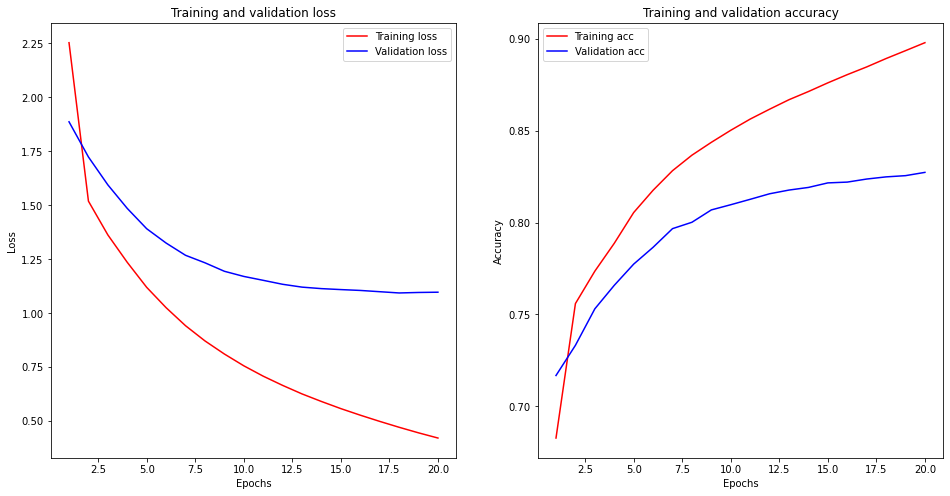

In [22]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(epochs, loss, 'r', label='Training loss')
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, acc, 'r', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [23]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_layer = Embedding(fra_vocab_size, hidden_units)

dec_emb2 = decoder_embedding_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [24]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [25]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = fra2idx['\t']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = idx2fra[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '\n' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [26]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          299008    
                                                                 
 masking (Masking)           (None, None, 64)          0         
                                                                 
 lstm (LSTM)                 [(None, 256),             328704    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 627,712
Trainable params: 627,712
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding2 = Embedding(fra_vocab_size, 256)(decoder_inputs) 

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding2, initial_state = decoder_states_inputs)

# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

- 무슨 일인지 mask값과 그냥 decoder_inputs은 오류가 생김

In [28]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_embedding2] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 256)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, None, 256),  525312      ['input_7[0][0]',                
                                 (None, 256),                     'input_5[0][0]',          

In [29]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [34]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [35]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

ValueError: ignored

## 6. 모델 구현하기

## 7. 모델 평가하기

## 8. 회고